In [1]:
import PatternStructure as ps
import AssociativeNetwork as nt
import functions as fs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from tqdm import tqdm
sns.set(style='white',font_scale=1.5)

In [16]:
# PARAMETERS
GAMMA = 0.5
XI = 0.1
N_CELLS = 1000
N_PATTERNS = 64 # P
CELLS_PER_PATTERN = 100 
N_CHAINS = 1 # M
PATTERNS_PER_CHAIN = 64 # Q

DYNAMIC_SPARISTY = .2*(CELLS_PER_PATTERN/N_CELLS)

In [17]:
#Memory structure
kernel = ps.InteractionKernel(gamma=GAMMA,xi=XI)
memories = ps.PatternStructure(n_cells=N_CELLS,
                            n_patterns=N_PATTERNS,
                            cells_per_pattern=CELLS_PER_PATTERN,
                            n_chains=N_CHAINS,
                            patterns_per_chain=PATTERNS_PER_CHAIN,
                            kernel=kernel)


memories.generate_patterns()
memories.generate_chains()
memories.build_interactions()

In [18]:
len(memories.patterns)

64

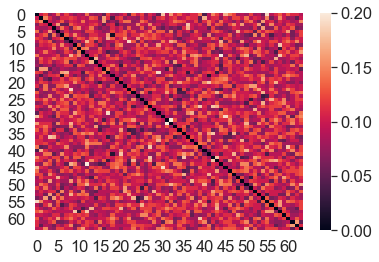

In [19]:
pattern_overlap = ps.pattern_overlap_matrix(memories)
sns.heatmap(pattern_overlap);

<AxesSubplot:>

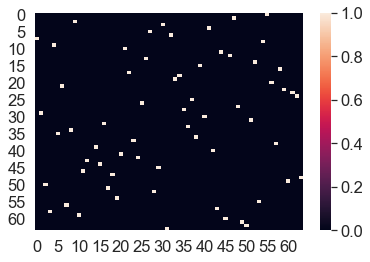

In [20]:
G = nx.from_numpy_matrix(memories.chain_transitions)
sns.heatmap(memories.chain_transitions)

In [21]:
starting_map = 1
net = nt.Network(J=memories.interaction_matrix, 
                 transfer_func=nt.ReLu,
                 dynamic_func=nt.net_dynamics)

initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1)
initial_config = initial_config/np.mean(initial_config)
net.run_dynamics(initial_config,n_steps=100,sparsity=DYNAMIC_SPARISTY)

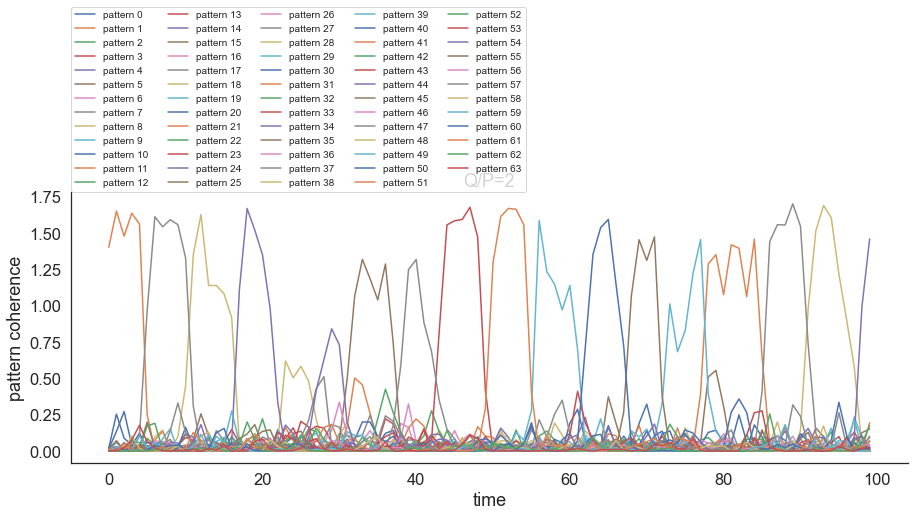

In [22]:
coherence = fs.coherence_timecourse(memories,net.history)
attractors = fs.attractors_timecourse(memories,net.history)
retrieved_sequence = fs.retrieved_sequence(memories,net.history)

plt.figure(figsize=(15,5))
for i,timecourse in enumerate(coherence):
    plt.plot(timecourse,label=f'pattern {i}')
plt.legend()

sns.despine()
plt.title('Q/P=2')
plt.xlabel('time')
plt.ylabel('pattern coherence')
plt.legend(fontsize = 10,loc=(0,1),ncol=5)

In [25]:
compute_retrieval_quality(coherence)

1.1772473921063098

In [26]:
compute_obedience(retrieved_sequence,memories.chain_transitions)

0.8333333333333334

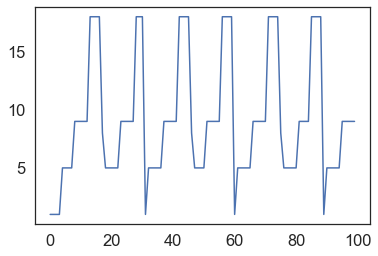

In [11]:
plt.plot(attractors)

In [9]:
import matplotlib.pyplot as plt
from ipywidgets import interact,fixed
import ipywidgets as widgets


def plot_frame(m,i):
    fig = plt.figure(figsize=(10,5))
    v = net.history[i]
    x = [memories.patterns[m][cell] for cell in memories.patterns[m].keys()]
    idxs = [cell for cell in memories.patterns[m].keys()]
    plt.scatter(x,v[idxs])

def plot_dynamics():
    interact(plot_frame,
             m = widgets.IntSlider(min=0, max=(len(memories.patterns)-1), value=0),
             i = widgets.IntSlider(min=0, max=(len(net.history)-1), value=0))




In [10]:
plot_dynamics()

interactive(children=(IntSlider(value=0, description='m', max=19), IntSlider(value=0, description='i', max=99)…

# SIMULATION

In [27]:
# PARAMETERS
GAMMA = 0.5
XI = 0.1
N_CELLS = 1000
N_PATTERNS = 40 # P
CELLS_PER_PATTERN = 100 


DYNAMIC_SPARISTY = .2*(CELLS_PER_PATTERN/N_CELLS)

N_CHAINS = [1,2,4,5,10,20,40] # M
PATTERNS_PER_CHAIN = N_CHAINS[::-1] # Q

N_STEPS = 200 #number of dynamic steps
N_DRAWS = 20

In [28]:
simulation_data = {'M':[],'Q':[],'draw':[],'retrieval_quality':[],'obedience':[]}

for i in range(len(N_CHAINS)):
    n_chains = N_CHAINS[i]
    patterns_per_chain = PATTERNS_PER_CHAIN[i]
    print(f'Computing P={N_PATTERNS}, M={n_chains},Q={patterns_per_chain}')

    for d in tqdm(range(N_DRAWS)):

        #Memory structure
        kernel = ps.InteractionKernel(gamma=GAMMA,xi=XI)
        memories = ps.PatternStructure(n_cells=N_CELLS,
                                    n_patterns=N_PATTERNS,
                                    cells_per_pattern=CELLS_PER_PATTERN,
                                    n_chains=n_chains,
                                    patterns_per_chain=patterns_per_chain,
                                    kernel=kernel)
        memories.generate_patterns()
        memories.generate_chains()
        memories.build_interactions()

        #initialize network
        net = nt.Network(J=memories.interaction_matrix, 
                        transfer_func=nt.ReLu,
                        dynamic_func=nt.net_dynamics)

        #run dynamics
        starting_map = np.random.choice(N_PATTERNS)
        initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1)
        initial_config = initial_config/np.mean(initial_config)
        net.run_dynamics(initial_config,n_steps=N_STEPS,sparsity=DYNAMIC_SPARISTY)

        coherence = fs.coherence_timecourse(memories,net.history)
        retrieved_sequence = fs.retrieved_sequence(memories,net.history)
        

        simulation_data['M'].append(n_chains)
        simulation_data['Q'].append(patterns_per_chain)
        simulation_data['draw'].append(d)
        simulation_data['retrieval_quality'].append(compute_retrieval_quality(coherence))
        simulation_data['obedience'].append(compute_obedience(retrieved_sequence,memories.chain_transitions))
        

    
simulation_data = pd.DataFrame(simulation_data)

    

  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=1,Q=40


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=2,Q=20


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=4,Q=10


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=5,Q=5


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=10,Q=4


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=20,Q=2


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=40,Q=1


100%|██████████| 20/20 [02:09<00:00,  6.47s/it]


In [29]:
simulation_data = pd.DataFrame(simulation_data)


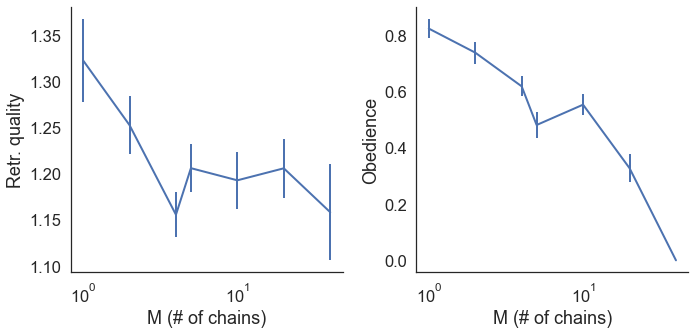

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
x = np.unique(simulation_data['M'])
y = simulation_data.groupby('M').mean()['retrieval_quality']
err =  simulation_data.groupby('M').sem()['retrieval_quality']
plt.errorbar(x,y,err,linewidth=2)
plt.xscale('log')
plt.xlabel('M (# of chains)')
plt.ylabel('Retr. quality')
sns.despine()

plt.subplot(1,2,2)
x = np.unique(simulation_data['M'])
y = simulation_data.groupby('M').mean()['obedience']
err =  simulation_data.groupby('M').sem()['obedience']
plt.errorbar(x,y,err,linewidth=2)
plt.xscale('log')
plt.xlabel('M (# of chains)')
plt.ylabel('Obedience')

sns.despine()

plt.tight_layout()

# fixed lenght, more chains

In [33]:
# PARAMETERS
GAMMA = 0.5
XI = 0.1
N_CELLS = 1000
N_PATTERNS = 40 # P
CELLS_PER_PATTERN = 100 


DYNAMIC_SPARISTY = .2*(CELLS_PER_PATTERN/N_CELLS)

N_CHAINS = [1,2,4,5,10,20,40] # M
PATTERNS_PER_CHAIN = [30] # Q

N_STEPS = 200 #number of dynamic steps
N_DRAWS = 20

In [35]:
simulation_data = {'M':[],'Q':[],'draw':[],'retrieval_quality':[],'obedience':[]}

for i in range(len(N_CHAINS)):
    n_chains = N_CHAINS[i]
    patterns_per_chain = PATTERNS_PER_CHAIN[0]
    print(f'Computing P={N_PATTERNS}, M={n_chains},Q={patterns_per_chain}')

    for d in tqdm(range(N_DRAWS)):

        #Memory structure
        kernel = ps.InteractionKernel(gamma=GAMMA,xi=XI)
        memories = ps.PatternStructure(n_cells=N_CELLS,
                                    n_patterns=N_PATTERNS,
                                    cells_per_pattern=CELLS_PER_PATTERN,
                                    n_chains=n_chains,
                                    patterns_per_chain=patterns_per_chain,
                                    kernel=kernel)
        memories.generate_patterns()
        memories.generate_chains()
        memories.build_interactions()

        #initialize network
        net = nt.Network(J=memories.interaction_matrix, 
                        transfer_func=nt.ReLu,
                        dynamic_func=nt.net_dynamics)

        #run dynamics
        starting_map = np.random.choice(N_PATTERNS)
        initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1)
        initial_config = initial_config/np.mean(initial_config)
        net.run_dynamics(initial_config,n_steps=N_STEPS,sparsity=DYNAMIC_SPARISTY)

        coherence = fs.coherence_timecourse(memories,net.history)
        retrieved_sequence = fs.retrieved_sequence(memories,net.history)
        

        simulation_data['M'].append(n_chains)
        simulation_data['Q'].append(patterns_per_chain)
        simulation_data['draw'].append(d)
        simulation_data['retrieval_quality'].append(compute_retrieval_quality(coherence))
        simulation_data['obedience'].append(compute_obedience(retrieved_sequence,memories.chain_transitions))
        

    
simulation_data = pd.DataFrame(simulation_data)

  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=1,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=2,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=4,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=5,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=10,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=20,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=40,Q=30


100%|██████████| 20/20 [24:14<00:00, 72.73s/it]


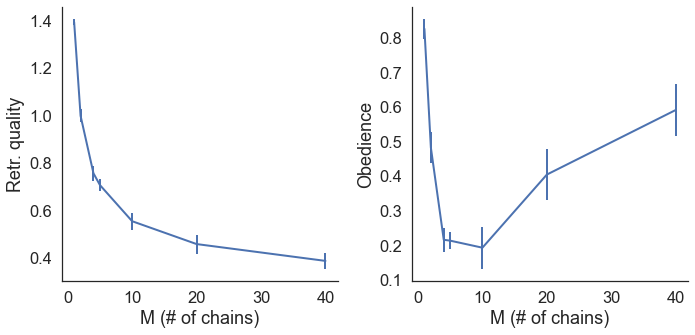

In [39]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
x = np.unique(simulation_data['M'])
y = simulation_data.groupby('M').mean()['retrieval_quality']
err =  simulation_data.groupby('M').sem()['retrieval_quality']
plt.errorbar(x,y,err,linewidth=2)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('M (# of chains)')
plt.ylabel('Retr. quality')
sns.despine()

plt.subplot(1,2,2)
x = np.unique(simulation_data['M'])
y = simulation_data.groupby('M').mean()['obedience']
err =  simulation_data.groupby('M').sem()['obedience']
plt.errorbar(x,y,err,linewidth=2)
#plt.xscale('log')
plt.xlabel('M (# of chains)')
plt.ylabel('Obedience')

sns.despine()

plt.tight_layout()